# Nagel−Schreckenberg Traffic Model

The Nagel-Schreckenberg model is a discrete model of traffic congestion. 
The model divides a circular road into $M$ road segments. There are $N$ cars on it, and each segment can contain only one car at any time. The speeds of the cars are non-negative integers $0 \leq v_i(t) \leq v_{max}$.

In [458]:
road_segments = 1000 # M
number_cars = 103    # N
max_speed = 5       # v_max

The initial state of the model is random. Cars are placed at random at locations on the road without repetition.

In [459]:
import numpy as np
import pandas as pd

from numpy.random import MT19937, RandomState, SeedSequence
RSTATE = RandomState(MT19937(SeedSequence(987654321)))

def initial_state():
    return  pd.DataFrame({
        'x' : np.sort( RSTATE.choice( range(road_segments), number_cars, replace=False) ),
        'v' : np.full( number_cars, 0),
        't' : 0,
        'ix': range(number_cars)
    })

The drivers want to get to their destination as fast as possible. For each time step, the drivers:

1. Speed up unless at max speed
   $$
     v_i^1(t+1) = \min( v_i(t)+1, v_{max})
   $$
2. If the speed $v_i$ is greater or equal to the distance $d$ to the next car, the driver
   slows down to $d-1$. In other words, the speed is reduced such that the car advances to
   the last unoccupied slot behind the car in front's current location. Distance is calculated
   modulo $M$ for the last and first car on the circular road.
   $$
     v_i^2(t+1) = \min( v_{i+1}^1(t+1), d)
   $$
3. The driver then randomly slows down with probability $p$ unless already at a standstill
   $$
     v(t+1) = \begin{cases}
       \max( v_i^2(t+1) - 1, 0) & \textrm{with probaiblity $p$} \\
       v_i^2(t+1) & \textrm{otherwise}
     \end{cases}


In [460]:
prob_slowdown = 1/3  # probility of slow down

def speedup(v):
    return np.minimum( v+1, max_speed)

def slowdown_if_close(x, v):
    d = np.mod( np.roll(x,-1) - x, road_segments )
    return np.minimum( v, d-1)

def random_slowdown(v):
    p = RSTATE.binomial(1, prob_slowdown, size=len(v))
    return np.maximum(v - p, 0)

def drive(df):
    v_new = speedup(df.v)
    v_new = slowdown_if_close(df.x, v_new)
    v_new = random_slowdown(v_new)
    x_new = np.mod( df.x + v_new, road_segments )
    return pd.DataFrame({'x': x_new, 'v': v_new, 't': df.t+1, 'ix': df.ix})

A simulation of the model shows how regions of congestion appear and disappear. The blue dots in the graph show the locations of the cars, with the red
dot indicating the location of the first car. The graph shows how the cars travel in the direction of the road, slow down when hitting traffic and the
region of congestion travels in the opposite direction.

Text(0, 0.5, 'Time')

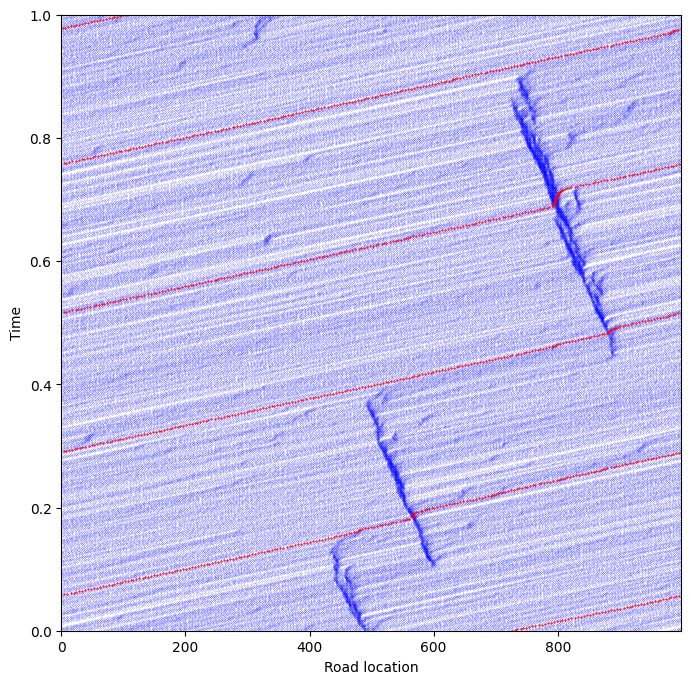

In [461]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# === initiate and burn in the model
df = initial_state()
for _ in range(2500):
    df = drive( df )

# === save range of simulation steps
df.t = 0
df_all = df.copy()
for _ in range(1000):
    df = drive( df )
    df_all = df_all.append(df)
df_all.t = df_all.t/np.max(df.t)

# === visualize
plt.figure(figsize=(8,8))
plt.plot(df_all.x, df_all.t, '.b', markersize=.3)
plt.plot(df_all.x[df_all.ix==0], df_all.t[df_all.ix==0], 'or', markersize=.5)
plt.xlim(0, road_segments-1)
plt.ylim(0, 1)
plt.xlabel('Road location')
plt.ylabel('Time')